# Image Preprocessing

## Preparation
### Import Modules

In [1]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.ticker as ticker
import tensorflow as tf
import numpy as np
import cv2
from python_code.image_preprocessing.pcb_visualization import PCBVisualizer

ROOT_DIR = os.path.join(os.curdir, '..', '..')

c:\MEIN_PLATZ\Git\pcb-defect-detection\venv\Lib\site-packages\tensorflow\python\framework\dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


### Load Data

In [2]:
KAGGLE_ANNO = os.path.join(ROOT_DIR, r'data/pcb_defects_kaggle/Annotations/annotation_summary.csv')

kaggle_data = pd.read_csv(KAGGLE_ANNO, sep=';') 

paths = []
targets = []
for _, sample in kaggle_data.iterrows():
    paths.append(os.path.join(ROOT_DIR, sample['path']))
    targets.append(tf.constant(sample['category_codes'], dtype=tf.int8))

image_dataset = tf.data.Dataset.from_tensor_slices((paths, targets))

### Decode Images to Tensorflow Dataset

In [3]:
def load_and_decode_image(*image_data):
    image = tf.io.read_file(image_data[0])
    image = tf.image.decode_jpeg(image, channels=3)
    return (image, image_data[1])

image_dataset = image_dataset.map(load_and_decode_image)

### Raw Images

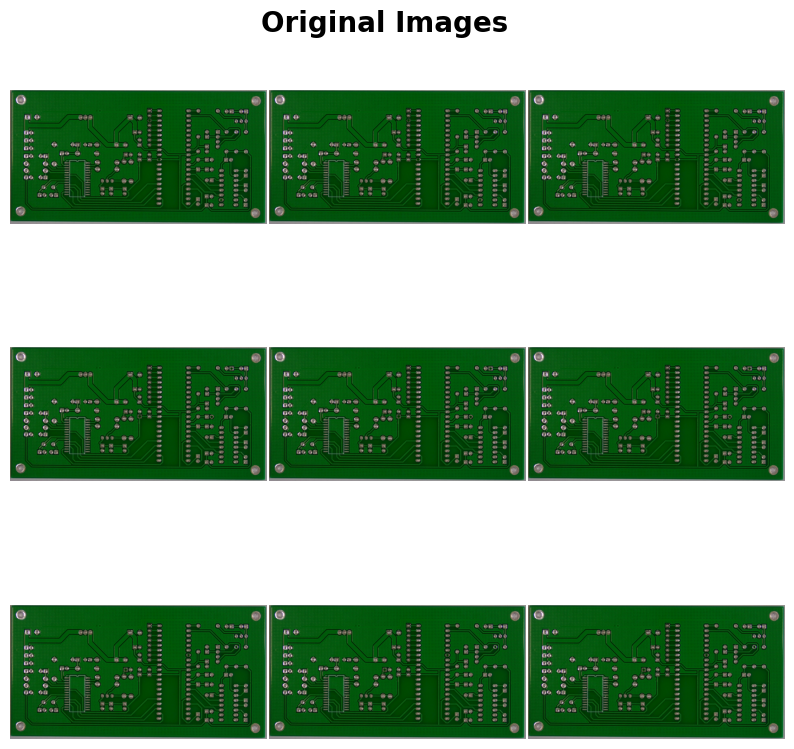

<Figure size 640x480 with 0 Axes>

In [4]:
pcb_visualizer = PCBVisualizer()
pcb_visualizer.plot_images(image_dataset, 'Original Images')


## Step 1: Image Aligment

In [5]:
#TODO

## Step 2: Histogram Equalization
### Implementation

In [6]:
def equalize_histogram(tf_image, tf_target):

    cv_img = tf_image.numpy().astype('uint8')
    
    # Apply histogram equalization to each of the RGB channels independently
    channels = cv2.split(cv_img)
    eq_channels = [cv2.equalizeHist(ch) for ch in channels]  
    cv2_eq_image = cv2.merge(eq_channels)
    
    tf_eq_image = tf.convert_to_tensor(cv2_eq_image, dtype=tf.int16) 
    
    return (tf_eq_image, tf_target)

# Using tf.py_function with the updated function signature
image_dataset_equalized = image_dataset.map(
    lambda img, tgt: tf.py_function(func=equalize_histogram, inp=[img, tgt], Tout=(tf.int16, tf.int8))
)

### Processed Images

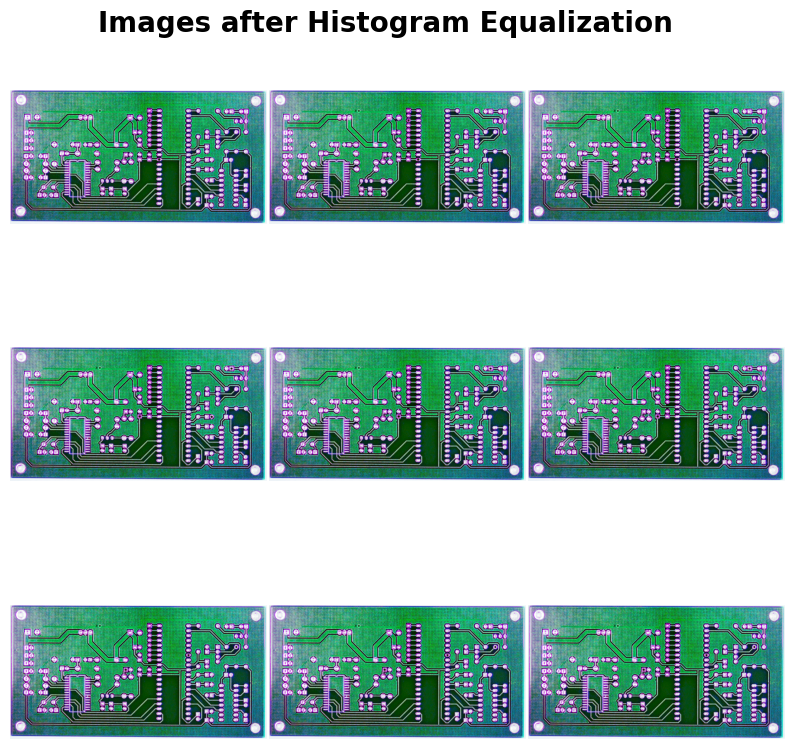

<Figure size 640x480 with 0 Axes>

In [7]:

pcb_visualizer.plot_images(image_dataset_equalized, 'Images after Histogram Equalization')

### Analysis Graphs

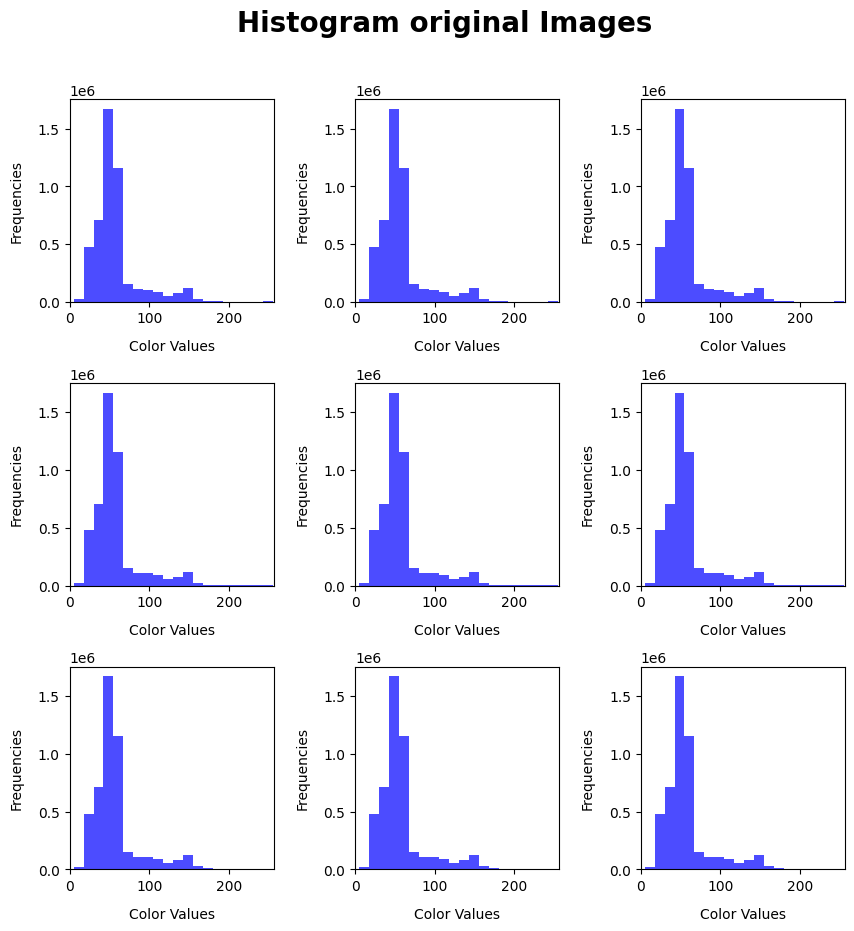

<Figure size 640x480 with 0 Axes>

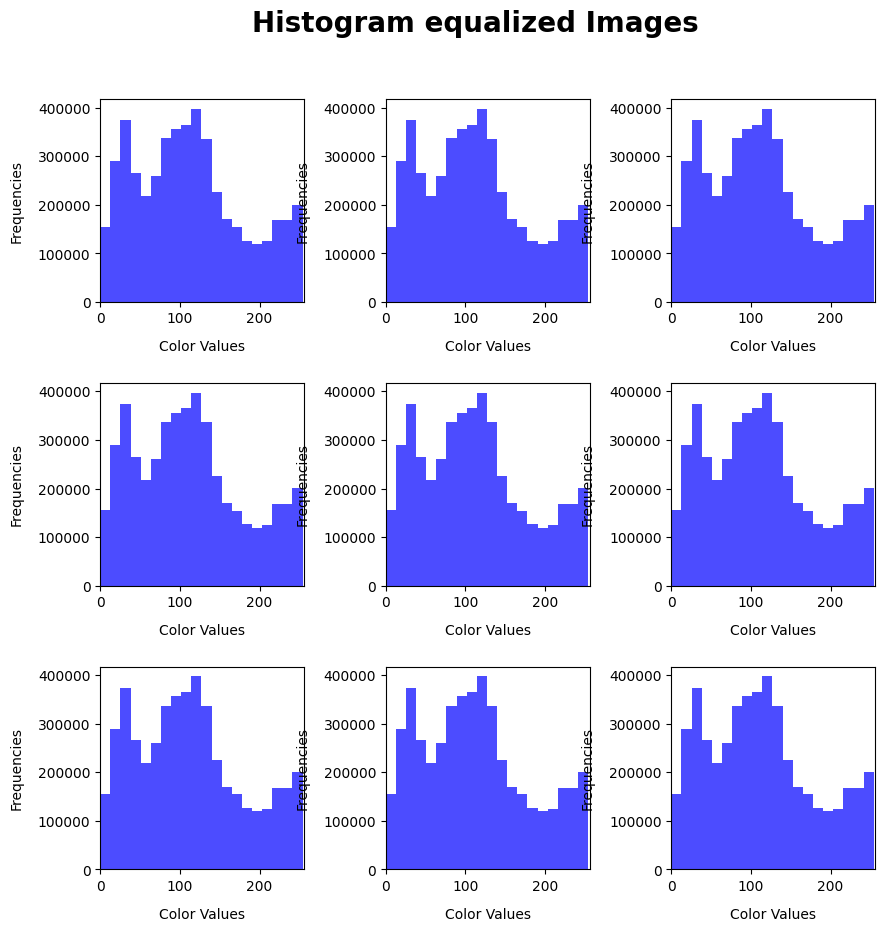

<Figure size 640x480 with 0 Axes>

In [8]:
pcb_visualizer.plot_histograms(image_dataset, 'Histogram original Images')
pcb_visualizer.plot_histograms(image_dataset_equalized, 'Histogram equalized Images')

### Discussion
The images ploted above show a higher contrast comperad to the input images. The improved contrast can help in defect detection, as subtle differences are more visible. This can be also seen in the histogram of the images after histogram equalization: Two peaks are visible representing the solder mask and the copper material. However, it seems also to have introduced or amplified noise. Therefore in the next step the images will be subject to noise reduction. 

## Step3: Noise Reduction

### Implementation

In [9]:
def gaussian_blur(tf_img, tf_target,  kernel_size=(5, 5)):
    cv_img = (tf_img.numpy()).astype('uint8')
    
    cv_blurred_image = cv2.GaussianBlur(cv_img, kernel_size, 0)
    
    tf_blurred_image = tf.convert_to_tensor(cv_blurred_image, dtype=tf.int16)
    
    return (tf_blurred_image, tf_target)

image_dataset_blurred = image_dataset_equalized.map(lambda img, tgt: tf.py_function(func=equalize_histogram, inp=[img, tgt], Tout=(tf.int16, tf.int8)))

### Processed Images

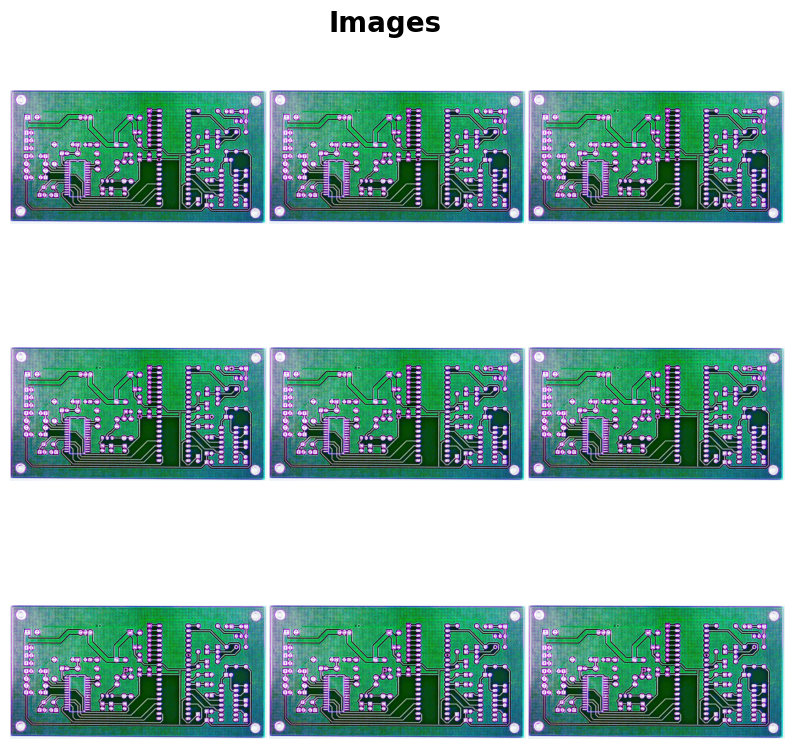

<Figure size 640x480 with 0 Axes>

In [10]:
pcb_visualizer.plot_images(image_dataset_blurred)

### Analysis Graphs

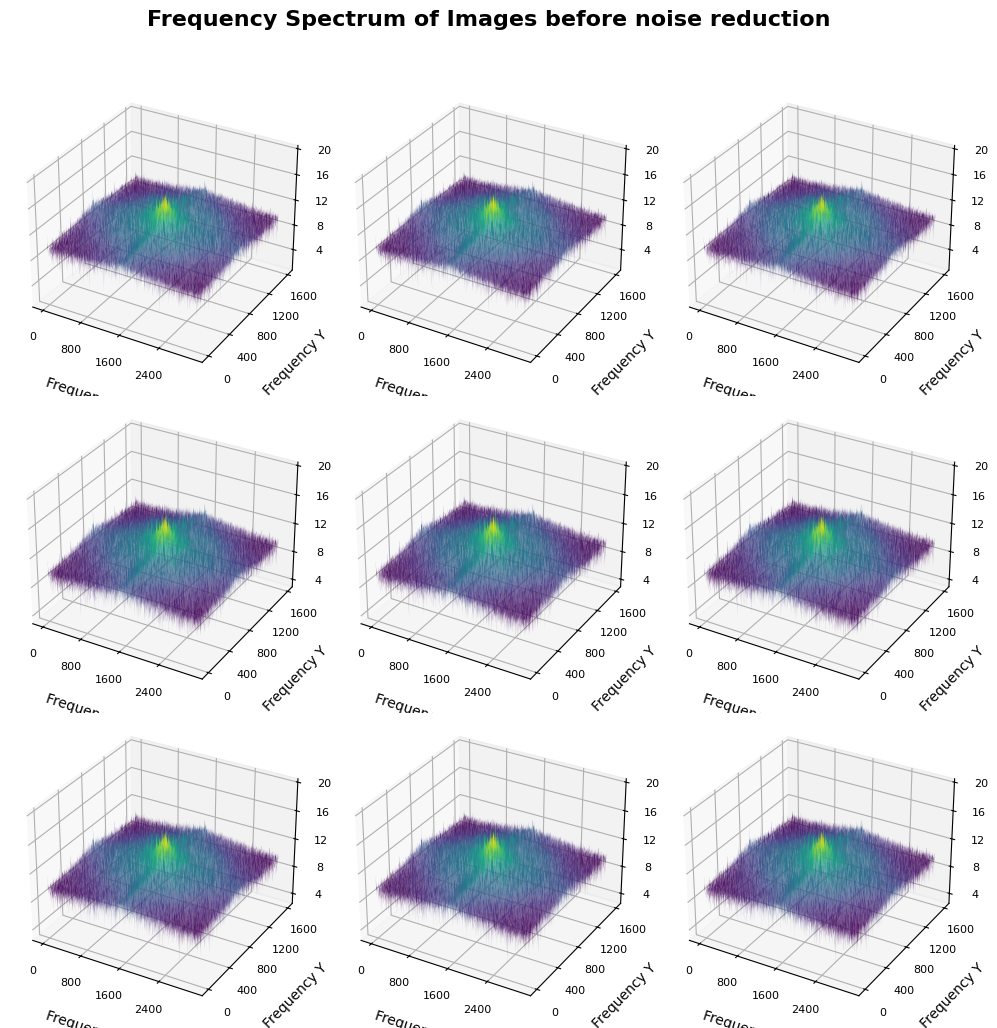

<Figure size 640x480 with 0 Axes>

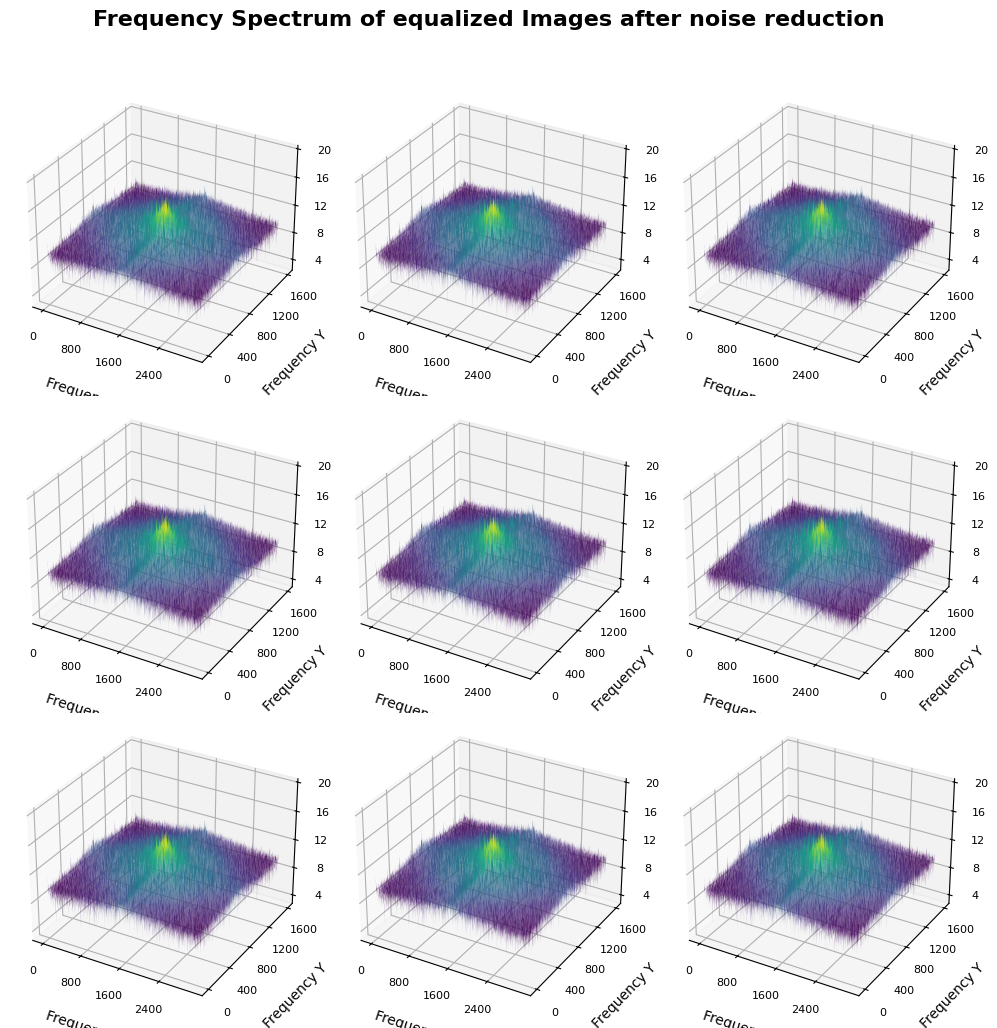

<Figure size 640x480 with 0 Axes>

In [11]:
pcb_visualizer.plot_frequency_spectrum_3D(image_dataset_equalized, 'Frequency Spectrum of Images before noise reduction')
pcb_visualizer.plot_frequency_spectrum_3D(image_dataset_blurred, 'Frequency Spectrum of equalized Images after noise reduction')

### Discussion
The processed images appear to be the same as before the noise reduction. However the frequency spectrums of the images show clear differences: The noise appears to be reduced and flattened.

## (Last Step Probably): Resizing

### Get Shape Statistics

In [12]:
widths = []
heights = []

for image in image_dataset:  
    shape = image[0].shape
    widths.append(shape[0])  
    heights.append(shape[1]) 

widths = np.array(widths)
heights = np.array(heights)

print("Mean Width:", widths.mean())
print("Mean Height:", heights.mean())
print("Std Dev Width:", widths.std())
print("Std Dev Height:", heights.std())
print("Min Width:", widths.min())
print("Min Height:", heights.min())
print("Max Width:", widths.max())
print("Max Height:", heights.max())


Mean Width: 2157.239756180156
Mean Height: 2736.1876058245853
Std Dev Width: 274.6939498536975
Std Dev Height: 265.22556582554705
Min Width: 1586
Min Height: 2240
Max Width: 2530
Max Height: 3056


The statitistics of the image shapes are useful to find the fixed shape to which the images will be resized.
The image will be resized to a square shape. Before resizing the images are brougth to a squared shape with padding.

### Implementation

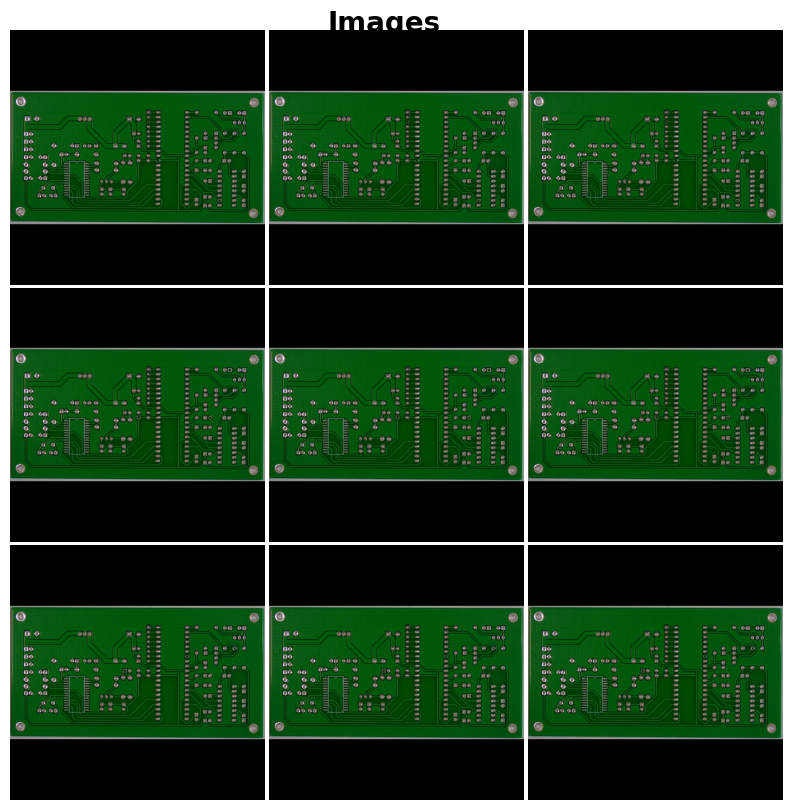

<Figure size 640x480 with 0 Axes>

In [16]:
DESIRED_H_AND_W = 2000

def resize_image(*tf_data):
    shape = tf.shape(tf_data[0])
    height, width = shape[0], shape[1]

    if height > width:
        pad_top = 0
        pad_bottom = 0
        pad_left = (height - width) // 2
        pad_right = height - width - pad_left
    else:
        pad_top = (width - height) // 2
        pad_bottom = width - height - pad_top
        pad_left = 0
        pad_right = 0

    tf_padded_img = tf.pad(tf_data[0], [[pad_top, pad_bottom], [pad_left, pad_right], [0, 0]])
    tf_resized_image = tf.image.resize(tf_padded_img, [DESIRED_H_AND_W, DESIRED_H_AND_W], method='nearest')

    return (tf_resized_image, tf_data[1]) 


image_dataset_resized = image_dataset.map(resize_image)
pcb_visualizer.plot_images(image_dataset_resized)